# 深度学习模型
特征：
1. 滑动窗口采样
设置windows size，采样前k个step预测下一个

2. 滑动窗口平均采样

模型：
1. MLP
2. CNN
3. LSTM
4. RCNN
5. RWKV

todo：
1. 加入额外特征embedding

In [4]:
import pandas as pd
import numpy as np
import random
import pickle
import math
import os
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [5]:
from dataclasses import dataclass

# 1 读取处理后数据

字典数据：
```
{
    'tid':[
        [cycle_count],
        [battery_life]
    ]
}
```

DataFrame数据：
```
columns = [tid,cycle_count,life]
```

In [6]:
bmap = pickle.load(open("../data/processed/nasa-li-battery_dict_240906.pkl",'rb'))

In [7]:
# ddf = pd.read_pickle('../data/processed/nasa-li-battery_df_240906.pkl')

# 2 特征采样和评价指标

## 2.1 特征采样

In [8]:
def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+1:i+1+window_size]

        x.append(sequence)
        y.append(target)
        
    return np.array(x), np.array(y)


# 留一评估：一组数据为测试集，其他所有数据全部拿来训练
def get_train_test(data_dict, name, window_size=8, train_ratio=0.):
    data_sequence=data_dict[name][1]
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_sequences(text=v[1], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
            
    return train_x, train_y, list(train_data), list(test_data)


def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse
    

def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re

## 2.2 训练和评价

In [9]:
from tqdm import tqdm

### 绘图函数

In [11]:
def plot(name,
         real_data, 
         pred_data):
    fig, ax = plt.subplots(1, figsize=(12, 8))

    plot_range = [i for i in range(len(real_data))]
    
    ax.plot(plot_range, real_data, 'b.', label=name)
    ax.plot(plot_range, pred_data, 'r.', label='Prediction')
    plt.plot([-1,170],[2*0.7, 2*0.7], c='black', lw=1, ls='--')  # 临界点直线
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
    plt.legend()

# 3 CNN

一维CNN，滑动窗口，在采样后的数据上做。

后续可考虑多层stack。

In [12]:
from typing import List,Dict,Tuple

In [13]:
from collections import OrderedDict

In [14]:
import torch

In [15]:
class NASALiBatteryDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 fpath:str,
                ):
        
        x_lst,y_lst = [],[]
        self.data_dict = pickle.load(open(fpath,'rb'))
        for name in self.data_dict.keys():
            train_x, train_y, train_data, test_data = get_train_test(self.data_dict, name, window_size)
            real_train_y = np.expand_dims(train_y[:,-1],-1)
            x_lst.append(train_x)
            y_lst.append(real_train_y)
        self.train_x = np.vstack(x_lst)
        self.train_y = np.vstack(y_lst)
        
    def __len__(self):
        return self.train_x.shape[0]
        
    def __getitem__(self, indices):
        
        return np.take(self.train_x,axis=0,indices=indices), np.take(self.train_y,axis=0,indices=indices)

In [16]:
class BaseModel(torch.nn.Module):

    def __init__(self, 
                 prefix_length:int=1,
                 device:str='cpu'):
        super(BaseModel, self).__init__()
        
        self.prefix_length = prefix_length
        self.device = device
    def __post_init__(self):
        self.double()
        
    def decode(self,
               input_x:np.array,
               max_length:int):
        '''
        input_x: List(prefix_length, )
        max_length: target decode length
        '''
        if not self.prefix_length != len(input_x):
            assert(f'Error input sequence must be prefix_length shape:{self.prefix_length}')

        test_x = input_x
        
        # decode to target length
        for i in range(max_length+1):
            online_x = np.array(test_x[-self.prefix_length:])
            online_x = torch.tensor(online_x).reshape((1,online_x.shape[0])).double().to(self.device)
            test_x += self.forward(online_x).flatten().detach().numpy().tolist() #测试值加入原来序列用来继续预测下一个点

        # list
        return test_x
        
    def forward(self, 
                x:torch.Tensor):
        '''
        x: (prefix_length, )
        '''
        pass

In [17]:
class CNNSingleModel(BaseModel):

    def __init__(self,
                 kernel_size:int,
                 stride:int,
                 prefix_length:int=1,
                 device:str='cpu'):
        super(CNNSingleModel, self).__init__(
            prefix_length=prefix_length,
               device=device
        )
        if kernel_size>self.prefix_length:
            assert(f'Error kernel_size:{kernel_size} must less than prefix_length:{self.prefix_length}')
        
        self.CNNLayer = torch.nn.Conv1d(in_channels=1,
                                        out_channels=1,
                                        kernel_size=kernel_size,
                                        stride=stride)
        
        self.OutputLinear = torch.nn.Linear(in_features=int((self.prefix_length-kernel_size+1)/stride),
                                            out_features=1,
                                            bias=False)
        self.__post_init__()
    def forward(self,
                x:torch.Tensor):
        x = x.reshape(x.shape[0],1,x.shape[1])
        x = self.CNNLayer(x)
        y = self.OutputLinear(x)
        return y.reshape((y.shape[0],1))

In [18]:
window_size = 32
epoch = 10_00_000
learning_rate = 1e-3    # learning rate
weight_decay = 0.0
kernel_size = 16
stride = 1
batch_size = 512

In [19]:
eval_step = 1000

In [20]:
data_dict = bmap

In [21]:
model = CNNSingleModel(kernel_size=kernel_size,
                       stride=stride,
                 prefix_length=window_size)

In [22]:
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay=weight_decay)
criterion = torch.nn.MSELoss()

In [23]:
on_test_log = True

In [24]:
train_dataset = NASALiBatteryDataset(fpath='../data/processed/nasa-li-battery_dict_240906.pkl')

In [25]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=False)

In [ ]:
loss_list = [0]
mae_lst,rmse_lst = [], []

for i in tqdm(range(epoch)):
    if i%eval_step==0 and on_test_log:
        print('---------------------------------------------------')
    for batch_x,batch_y in train_loader:
        output= model(batch_x)
        loss = criterion(output, batch_y)
        optimizer.zero_grad()              # clear gradients for this training step
        loss.backward()                    # backpropagation, compute gradients
        optimizer.step()                   # apply gradients

        loss_list.append(loss.detach().numpy().tolist())

    if i%eval_step==0:
        for name in data_dict.keys():
            train_x, train_y, train_data, test_data = get_train_test(data_dict, name, window_size)
            
            prefix_x = data_dict[name][1][:window_size]
            decode_seq = model.decode(prefix_x,max_length=len(test_data))[window_size+1:]
            mae, rmse = evaluation(y_test=test_data, y_predict=decode_seq)
            
            mae_lst.append(mae)
            rmse_lst.append(rmse)
        
        if on_test_log:
            print(f'Epoch:{i} Loss:{np.average(loss_list):.8f} MAE:{np.average(mae_lst):.4f} | RMSE:{np.average(rmse_lst):.4f}')

  0%|          | 7/1000000 [00:00<4:15:11, 65.31it/s]

---------------------------------------------------
Epoch:0 Loss:2.37445749 MAE:1.4781 | RMSE:1.4896


  0%|          | 1016/1000000 [00:09<2:44:47, 101.03it/s]

---------------------------------------------------
Epoch:1000 Loss:0.04521629 MAE:0.7662 | RMSE:0.7753


  0%|          | 2015/1000000 [00:19<2:51:50, 96.79it/s] 

---------------------------------------------------
Epoch:2000 Loss:0.02320470 MAE:0.5280 | RMSE:0.5362


  0%|          | 3009/1000000 [00:28<2:51:04, 97.13it/s] 

---------------------------------------------------
Epoch:3000 Loss:0.01573040 MAE:0.4080 | RMSE:0.4162


  0%|          | 4005/1000000 [00:37<2:49:37, 97.87it/s] 

---------------------------------------------------
Epoch:4000 Loss:0.01193998 MAE:0.3364 | RMSE:0.3445


  1%|          | 5010/1000000 [00:47<2:50:53, 97.04it/s] 

---------------------------------------------------
Epoch:5000 Loss:0.00964591 MAE:0.2886 | RMSE:0.2967


  1%|          | 6016/1000000 [00:56<2:39:01, 104.18it/s]

---------------------------------------------------
Epoch:6000 Loss:0.00810624 MAE:0.2543 | RMSE:0.2623


  1%|          | 7016/1000000 [01:06<2:42:11, 102.04it/s]

---------------------------------------------------
Epoch:7000 Loss:0.00700056 MAE:0.2288 | RMSE:0.2366


  1%|          | 8011/1000000 [01:15<2:51:52, 96.19it/s] 

---------------------------------------------------
Epoch:8000 Loss:0.00616788 MAE:0.2094 | RMSE:0.2171


  1%|          | 9013/1000000 [01:25<2:43:47, 100.84it/s]

---------------------------------------------------
Epoch:9000 Loss:0.00551835 MAE:0.1944 | RMSE:0.2020


  1%|          | 10014/1000000 [01:34<2:50:56, 96.53it/s] 

---------------------------------------------------
Epoch:10000 Loss:0.00499770 MAE:0.1824 | RMSE:0.1899


  1%|          | 11008/1000000 [01:44<2:52:29, 95.56it/s] 

---------------------------------------------------
Epoch:11000 Loss:0.00457112 MAE:0.1726 | RMSE:0.1801


  1%|          | 12006/1000000 [01:53<2:45:35, 99.45it/s] 

---------------------------------------------------
Epoch:12000 Loss:0.00421529 MAE:0.1644 | RMSE:0.1719


  1%|▏         | 13012/1000000 [02:03<2:53:54, 94.59it/s] 

---------------------------------------------------
Epoch:13000 Loss:0.00391397 MAE:0.1574 | RMSE:0.1649


  1%|▏         | 14014/1000000 [02:12<2:33:47, 106.85it/s]

---------------------------------------------------
Epoch:14000 Loss:0.00365554 MAE:0.1514 | RMSE:0.1589


  2%|▏         | 15016/1000000 [02:22<2:41:46, 101.48it/s]

---------------------------------------------------
Epoch:15000 Loss:0.00343146 MAE:0.1462 | RMSE:0.1537


  2%|▏         | 16018/1000000 [02:31<2:39:16, 102.97it/s]

---------------------------------------------------
Epoch:16000 Loss:0.00323531 MAE:0.1416 | RMSE:0.1491


  2%|▏         | 17006/1000000 [02:40<2:46:36, 98.33it/s] 

---------------------------------------------------
Epoch:17000 Loss:0.00306218 MAE:0.1375 | RMSE:0.1450


  2%|▏         | 18017/1000000 [02:50<2:37:11, 104.12it/s]

---------------------------------------------------
Epoch:18000 Loss:0.00290823 MAE:0.1338 | RMSE:0.1413


  2%|▏         | 19009/1000000 [02:59<3:03:01, 89.33it/s] 

---------------------------------------------------
Epoch:19000 Loss:0.00277046 MAE:0.1305 | RMSE:0.1380


  2%|▏         | 20013/1000000 [03:09<2:41:39, 101.03it/s]

---------------------------------------------------
Epoch:20000 Loss:0.00264643 MAE:0.1275 | RMSE:0.1350


  2%|▏         | 21015/1000000 [03:19<2:58:25, 91.45it/s] 

---------------------------------------------------
Epoch:21000 Loss:0.00253419 MAE:0.1248 | RMSE:0.1323


  2%|▏         | 22015/1000000 [03:28<2:45:07, 98.72it/s] 

---------------------------------------------------
Epoch:22000 Loss:0.00243213 MAE:0.1223 | RMSE:0.1298


  2%|▏         | 23007/1000000 [03:37<2:49:58, 95.80it/s] 

---------------------------------------------------
Epoch:23000 Loss:0.00233892 MAE:0.1200 | RMSE:0.1275


  2%|▏         | 24005/1000000 [03:47<2:57:08, 91.83it/s] 

---------------------------------------------------
Epoch:24000 Loss:0.00225347 MAE:0.1179 | RMSE:0.1254


  3%|▎         | 25010/1000000 [03:56<2:53:25, 93.70it/s] 

---------------------------------------------------
Epoch:25000 Loss:0.00217483 MAE:0.1159 | RMSE:0.1234


  3%|▎         | 26015/1000000 [04:06<2:39:49, 101.57it/s]

---------------------------------------------------
Epoch:26000 Loss:0.00210223 MAE:0.1141 | RMSE:0.1216


  3%|▎         | 27012/1000000 [04:15<2:40:19, 101.15it/s]

---------------------------------------------------
Epoch:27000 Loss:0.00203500 MAE:0.1124 | RMSE:0.1199


  3%|▎         | 28009/1000000 [04:25<2:47:13, 96.87it/s] 

---------------------------------------------------
Epoch:28000 Loss:0.00197255 MAE:0.1108 | RMSE:0.1184


  3%|▎         | 29011/1000000 [04:34<2:48:06, 96.27it/s] 

---------------------------------------------------
Epoch:29000 Loss:0.00191441 MAE:0.1094 | RMSE:0.1169


  3%|▎         | 30016/1000000 [04:44<2:41:18, 100.22it/s]

---------------------------------------------------
Epoch:30000 Loss:0.00186013 MAE:0.1080 | RMSE:0.1155


  3%|▎         | 31010/1000000 [04:53<2:44:52, 97.96it/s] 

---------------------------------------------------
Epoch:31000 Loss:0.00180934 MAE:0.1067 | RMSE:0.1142


  3%|▎         | 32010/1000000 [05:03<2:49:41, 95.07it/s] 

---------------------------------------------------
Epoch:32000 Loss:0.00176172 MAE:0.1054 | RMSE:0.1130


  3%|▎         | 33013/1000000 [05:12<2:39:41, 100.92it/s]

---------------------------------------------------
Epoch:33000 Loss:0.00171698 MAE:0.1043 | RMSE:0.1118


  3%|▎         | 34009/1000000 [05:22<2:49:45, 94.84it/s] 

---------------------------------------------------
Epoch:34000 Loss:0.00167486 MAE:0.1032 | RMSE:0.1107


  4%|▎         | 35014/1000000 [05:31<2:38:43, 101.32it/s]

---------------------------------------------------
Epoch:35000 Loss:0.00163514 MAE:0.1022 | RMSE:0.1097


  4%|▎         | 36015/1000000 [05:41<2:47:34, 95.87it/s] 

---------------------------------------------------
Epoch:36000 Loss:0.00159763 MAE:0.1012 | RMSE:0.1087


  4%|▎         | 37010/1000000 [05:50<2:40:00, 100.30it/s]

---------------------------------------------------
Epoch:37000 Loss:0.00156213 MAE:0.1002 | RMSE:0.1077


  4%|▍         | 38010/1000000 [06:00<2:53:58, 92.16it/s] 

---------------------------------------------------
Epoch:38000 Loss:0.00152850 MAE:0.0993 | RMSE:0.1069


  4%|▍         | 39007/1000000 [06:09<2:40:55, 99.53it/s] 

---------------------------------------------------
Epoch:39000 Loss:0.00149659 MAE:0.0985 | RMSE:0.1060


  4%|▍         | 40014/1000000 [06:19<2:32:39, 104.81it/s]

---------------------------------------------------
Epoch:40000 Loss:0.00146628 MAE:0.0977 | RMSE:0.1052


  4%|▍         | 41007/1000000 [06:28<2:47:55, 95.18it/s] 

---------------------------------------------------
Epoch:41000 Loss:0.00143744 MAE:0.0969 | RMSE:0.1044


  4%|▍         | 42005/1000000 [06:38<2:46:07, 96.11it/s] 

---------------------------------------------------
Epoch:42000 Loss:0.00140996 MAE:0.0962 | RMSE:0.1037


  4%|▍         | 43007/1000000 [06:47<2:39:08, 100.22it/s]

---------------------------------------------------
Epoch:43000 Loss:0.00138377 MAE:0.0955 | RMSE:0.1030


  4%|▍         | 44005/1000000 [06:57<2:37:06, 101.42it/s]

---------------------------------------------------
Epoch:44000 Loss:0.00135876 MAE:0.0948 | RMSE:0.1023


  5%|▍         | 45017/1000000 [07:06<2:37:48, 100.86it/s]

---------------------------------------------------
Epoch:45000 Loss:0.00133486 MAE:0.0941 | RMSE:0.1017


  5%|▍         | 46012/1000000 [07:16<2:40:49, 98.87it/s] 

---------------------------------------------------
Epoch:46000 Loss:0.00131200 MAE:0.0935 | RMSE:0.1010


  5%|▍         | 47015/1000000 [07:25<2:39:23, 99.65it/s] 

---------------------------------------------------
Epoch:47000 Loss:0.00129010 MAE:0.0929 | RMSE:0.1004


  5%|▍         | 48012/1000000 [07:34<2:46:04, 95.54it/s] 

---------------------------------------------------
Epoch:48000 Loss:0.00126912 MAE:0.0923 | RMSE:0.0998


  5%|▍         | 49012/1000000 [07:44<2:43:18, 97.05it/s] 

---------------------------------------------------
Epoch:49000 Loss:0.00124900 MAE:0.0918 | RMSE:0.0993


  5%|▌         | 50014/1000000 [07:54<2:47:33, 94.49it/s] 

---------------------------------------------------
Epoch:50000 Loss:0.00122967 MAE:0.0912 | RMSE:0.0987


  5%|▌         | 51011/1000000 [08:03<2:49:49, 93.13it/s] 

---------------------------------------------------
Epoch:51000 Loss:0.00121111 MAE:0.0907 | RMSE:0.0982


  5%|▌         | 52016/1000000 [08:13<2:34:57, 101.96it/s]

---------------------------------------------------
Epoch:52000 Loss:0.00119325 MAE:0.0902 | RMSE:0.0977


  5%|▌         | 53005/1000000 [08:22<2:44:01, 96.23it/s] 

---------------------------------------------------
Epoch:53000 Loss:0.00117607 MAE:0.0897 | RMSE:0.0972


  5%|▌         | 54013/1000000 [08:32<2:27:31, 106.87it/s]

---------------------------------------------------
Epoch:54000 Loss:0.00115953 MAE:0.0893 | RMSE:0.0968


  6%|▌         | 55012/1000000 [08:41<2:37:33, 99.96it/s] 

---------------------------------------------------
Epoch:55000 Loss:0.00114358 MAE:0.0888 | RMSE:0.0963


  6%|▌         | 56014/1000000 [08:51<2:53:04, 90.90it/s] 

---------------------------------------------------
Epoch:56000 Loss:0.00112820 MAE:0.0884 | RMSE:0.0959


  6%|▌         | 57012/1000000 [09:00<2:40:14, 98.08it/s] 

---------------------------------------------------
Epoch:57000 Loss:0.00111337 MAE:0.0880 | RMSE:0.0954


  6%|▌         | 58012/1000000 [09:09<2:40:52, 97.59it/s] 

---------------------------------------------------
Epoch:58000 Loss:0.00109904 MAE:0.0875 | RMSE:0.0950


  6%|▌         | 59013/1000000 [09:19<2:34:49, 101.30it/s]

---------------------------------------------------
Epoch:59000 Loss:0.00108520 MAE:0.0871 | RMSE:0.0946


  6%|▌         | 60016/1000000 [09:28<2:34:26, 101.44it/s]

---------------------------------------------------
Epoch:60000 Loss:0.00107181 MAE:0.0868 | RMSE:0.0942


  6%|▌         | 61015/1000000 [09:38<2:41:53, 96.67it/s] 

---------------------------------------------------
Epoch:61000 Loss:0.00105887 MAE:0.0864 | RMSE:0.0939


  6%|▌         | 62012/1000000 [09:47<2:47:55, 93.10it/s] 

---------------------------------------------------
Epoch:62000 Loss:0.00104634 MAE:0.0860 | RMSE:0.0935


  6%|▋         | 63009/1000000 [09:57<2:52:17, 90.64it/s] 

---------------------------------------------------
Epoch:63000 Loss:0.00103421 MAE:0.0857 | RMSE:0.0931


  6%|▋         | 64017/1000000 [10:06<2:33:08, 101.87it/s]

---------------------------------------------------
Epoch:64000 Loss:0.00102246 MAE:0.0853 | RMSE:0.0928


  7%|▋         | 65014/1000000 [10:16<2:38:50, 98.11it/s] 

---------------------------------------------------
Epoch:65000 Loss:0.00101107 MAE:0.0850 | RMSE:0.0924


  7%|▋         | 66008/1000000 [10:25<2:38:14, 98.38it/s] 

---------------------------------------------------
Epoch:66000 Loss:0.00100002 MAE:0.0846 | RMSE:0.0921


  7%|▋         | 67007/1000000 [10:35<2:33:14, 101.47it/s]

---------------------------------------------------
Epoch:67000 Loss:0.00098931 MAE:0.0843 | RMSE:0.0918


  7%|▋         | 68011/1000000 [10:44<2:41:45, 96.02it/s] 

---------------------------------------------------
Epoch:68000 Loss:0.00097891 MAE:0.0840 | RMSE:0.0915


  7%|▋         | 69005/1000000 [10:54<2:33:48, 100.88it/s]

---------------------------------------------------
Epoch:69000 Loss:0.00096880 MAE:0.0837 | RMSE:0.0912


  7%|▋         | 70010/1000000 [11:03<2:43:38, 94.72it/s] 

---------------------------------------------------
Epoch:70000 Loss:0.00095899 MAE:0.0834 | RMSE:0.0909


  7%|▋         | 71012/1000000 [11:13<2:29:07, 103.82it/s]

---------------------------------------------------
Epoch:71000 Loss:0.00094945 MAE:0.0831 | RMSE:0.0906


  7%|▋         | 72014/1000000 [11:22<2:33:27, 100.79it/s]

---------------------------------------------------
Epoch:72000 Loss:0.00094018 MAE:0.0828 | RMSE:0.0903


  7%|▋         | 73006/1000000 [11:32<2:41:22, 95.74it/s] 

---------------------------------------------------
Epoch:73000 Loss:0.00093116 MAE:0.0826 | RMSE:0.0900


  7%|▋         | 74013/1000000 [11:41<2:43:16, 94.52it/s] 

---------------------------------------------------
Epoch:74000 Loss:0.00092239 MAE:0.0823 | RMSE:0.0897


  8%|▊         | 75013/1000000 [11:50<2:31:54, 101.49it/s]

---------------------------------------------------
Epoch:75000 Loss:0.00091384 MAE:0.0820 | RMSE:0.0895


  8%|▊         | 76011/1000000 [12:00<2:40:06, 96.18it/s] 

---------------------------------------------------
Epoch:76000 Loss:0.00090552 MAE:0.0818 | RMSE:0.0892


  8%|▊         | 77013/1000000 [12:09<2:42:30, 94.66it/s] 

---------------------------------------------------
Epoch:77000 Loss:0.00089742 MAE:0.0815 | RMSE:0.0890


  8%|▊         | 78011/1000000 [12:19<2:53:00, 88.82it/s] 

---------------------------------------------------
Epoch:78000 Loss:0.00088953 MAE:0.0813 | RMSE:0.0887


  8%|▊         | 79012/1000000 [12:28<2:37:40, 97.35it/s] 

---------------------------------------------------
Epoch:79000 Loss:0.00088183 MAE:0.0811 | RMSE:0.0885


  8%|▊         | 80003/1000000 [12:38<2:43:33, 93.75it/s] 

---------------------------------------------------
Epoch:80000 Loss:0.00087433 MAE:0.0808 | RMSE:0.0882


  8%|▊         | 81008/1000000 [12:47<2:35:40, 98.38it/s] 

---------------------------------------------------
Epoch:81000 Loss:0.00086701 MAE:0.0806 | RMSE:0.0880


  8%|▊         | 83014/1000000 [13:28<2:30:53, 101.28it/s]

---------------------------------------------------
Epoch:83000 Loss:0.00085289 MAE:0.0802 | RMSE:0.0876


  8%|▊         | 83290/1000000 [13:31<2:17:33, 111.08it/s]

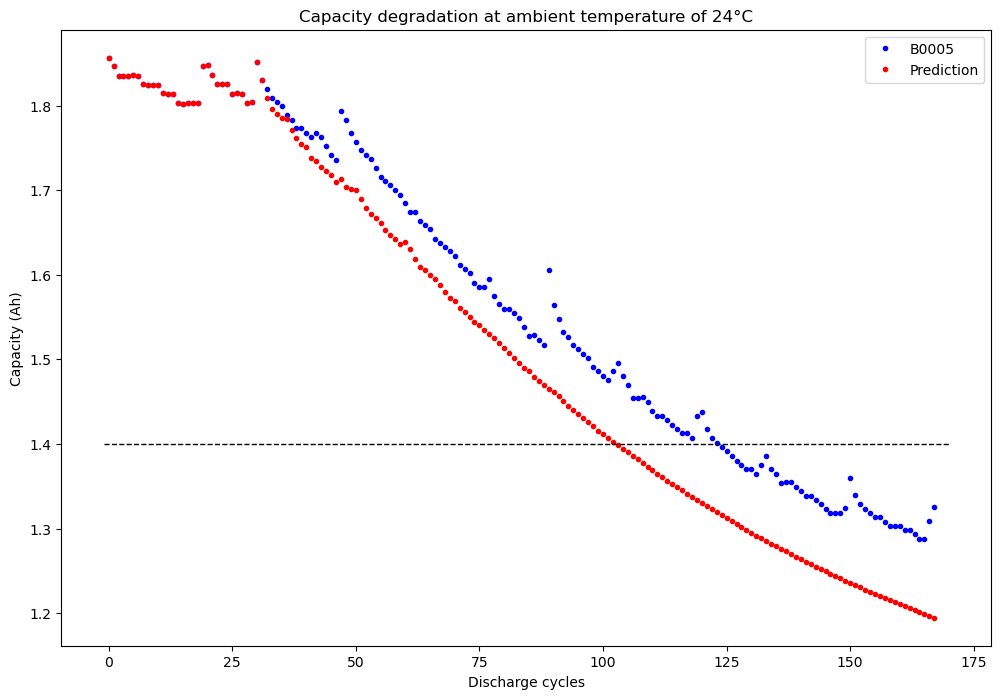

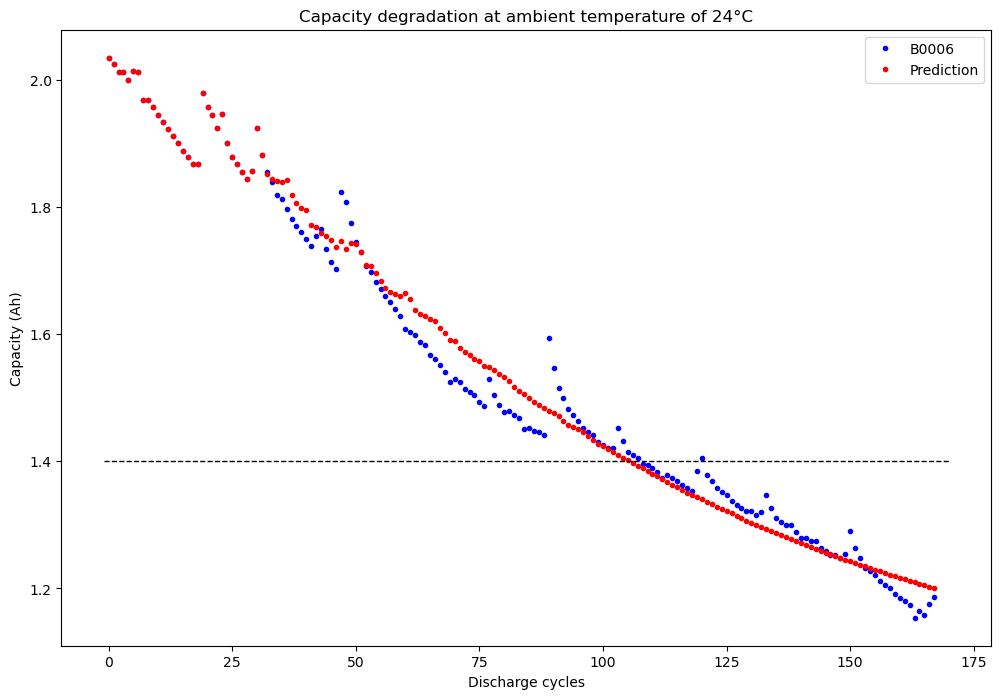

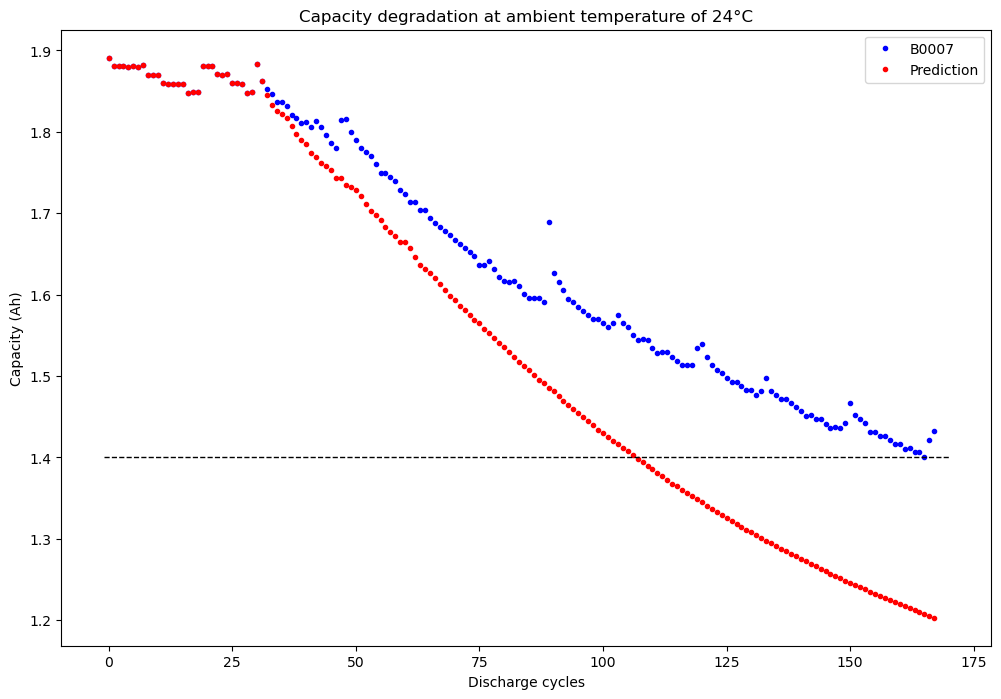

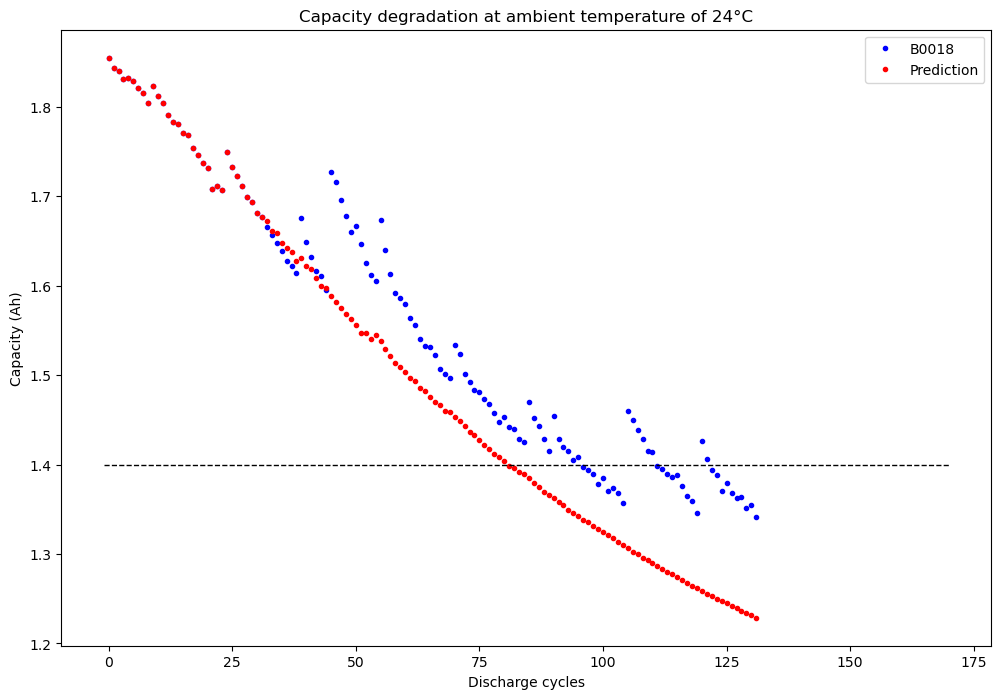

In [28]:
for name in data_dict.keys():
    train_x, train_y, train_data, test_data = get_train_test(data_dict, name, window_size)

    real = data_dict[name][1]
    prefix_x = data_dict[name][1][:window_size]
    decode_seq = model.decode(prefix_x,max_length=len(test_data))
    
    plot(name=name,
         real_data=real,
        pred_data=decode_seq)